# Probability

## TOC

* [Probability Distributions](#distributions)

## Probability distributions  <a class="anchor" id="probdist"></a>

In [18]:

import sklearn
import scipy
import scipy.optimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import itertools
import time
from functools import partial

import os
figdir = "../figures" # set this to '' if you don't want to save figures
def save_fig(fname):
    if figdir:
        plt.savefig(os.path.join(figdir, fname))

import numpy as onp
onp.set_printoptions(precision=3)
import jax
import jax.numpy as np
from jax import grad, hessian, jacfwd, jacrev, jit, vmap
from jax.experimental import optimizers
print("jax version {}".format(jax.__version__))
from jax.lib import xla_bridge
print("jax backend {}".format(xla_bridge.get_backend().platform))

import torch
import torchvision
print("torch version {}".format(torch.__version__))
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    print("current device {}".format(torch.cuda.current_device()))
else:
    print("Torch cannot find GPU")
    
import tensorflow as tf
from tensorflow import keras
print("tf version {}".format(tf.__version__))
if tf.test.is_gpu_available():
    print(tf.test.gpu_device_name())
else:
    print("TF cannot find GPU")


jax version 0.1.39
jax backend cpu
torch version 1.1.0
Torch cannot find GPU
tf version 2.0.0-dev20190629
TF cannot find GPU


## Distributions in scipy.stats  <a class="anchor" id="probdist-scipy"></a>

The [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) library has many common distributions. We illustrate them some of them below.


### Univariate Gaussian (normal)  <a class="anchor" id="scipy-unigauss"></a>


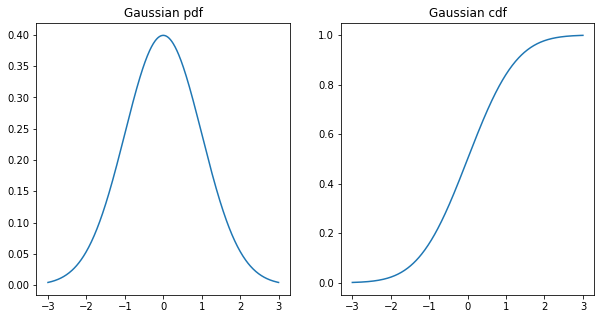

In [47]:
from scipy.stats import norm 

rv = norm(0, 1) # standard normal

fig, ax = plt.subplots(1,2, figsize=(10,5))
X = np.linspace(-3, 3, 500)
ax[0].plot(X, rv.pdf(X))
ax[0].set_title("Gaussian pdf")
ax[1].plot(X, rv.cdf(X))
ax[1].set_title("Gaussian cdf")
plt.show()


In [14]:
# Samples

onp.random.seed(42)
mu = 1.1
sigma = 0.1
dist = norm(loc=mu, scale=sigma) # create "frozen" distribution
N = 10
x = dist.rvs(size=N) # draw N random samples
print(x.shape)
print(x)

onp.random.seed(42)
x2 = norm(mu, sigma).rvs(size=N)
assert np.allclose(x, x2)



(10,)
[1.15  1.086 1.165 1.252 1.077 1.077 1.258 1.177 1.053 1.154]


In [15]:
# pdf, cdf, inverse cdf

logprob = dist.logpdf(x) # evaluate log probability of each sample
print(logprob.shape)

p = dist.cdf(x)
x3 = dist.ppf(p) # inverse CDF
assert np.allclose(x, x3)

(10,)


### Multivariate Gaussian (normal)  <a class="anchor" id="scipy-multigauss"></a>

In [7]:
from scipy.stats import multivariate_normal as mvn

D = 5
onp.random.seed(42)
mu = onp.random.randn(D)
A = onp.random.randn(D,D)
Sigma = np.dot(A, A.T)

dist = mvn(mu, Sigma)
X = dist.rvs(size=10)
print(X.shape) 

(10, 5)


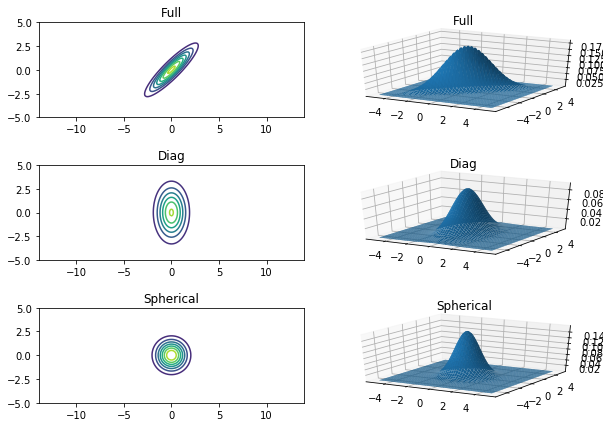

In [41]:
names = ["Full", "Diag", "Spherical"]

mu = [0, 0]
Covs = {'Full': [[2, 1.8], [1.8, 2]],
        'Diag': [[1, 0], [0, 3]],
        'Spherical': [[1, 0], [0, 1]]}

N = 100
points = np.linspace(-5, 5, N)
X, Y = np.meshgrid(points, points)
xs = X.reshape(-1)
ys = Y.reshape(-1)
grid = np.vstack([xs, ys]).T # N^2 * 2

fig = plt.figure(figsize=(10,7))
fig.subplots_adjust(hspace=0.5, wspace=0.1)
fig_counter = 1
for i in range(len(Covs)):
    name = names[i]
    Sigma = Covs[name]
    ps = mvn(mu, Sigma).pdf(grid)
    P = ps.reshape((N,N))

    ax = fig.add_subplot(3, 2, fig_counter)
    ax.contour(X, Y, P)
    ax.axis('equal') # make circles look circular
    ax.set_title(name)
    fig_counter = fig_counter + 1
    
    ax = fig.add_subplot(3, 2, fig_counter, projection='3d')
    ax.plot_surface(X, Y, P, rstride=2, cstride=2)
    ax.set_title(name)
    fig_counter = fig_counter + 1
plt.show()

### Gamma distribution  <a class="anchor" id="scipy-gamma"></a>

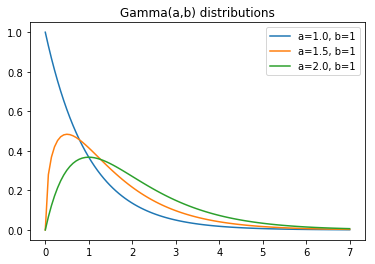

In [42]:
from scipy.stats import gamma

x = np.linspace(0, 7, 100)
b = 1
plt.figure()
for a in [1, 1.5, 2]:
    y = gamma.pdf(x, a, scale=1/b, loc=0)
    plt.plot(x, y)
plt.legend(['a=%.1f, b=1' % a for a in [1, 1.5, 2]])
plt.title('Gamma(a,b) distributions')
save_fig('gammaDistb1.pdf')
plt.show()


## Other libraries  <a class="anchor" id="probdist-other"></a>

The [Tensorflow distributions library](https://www.tensorflow.org/api_docs/python/tf/distributions)
has many common distributions, with an interface similar to scipy.stats.
 
The [Pytorch distributions library](https://pytorch.org/docs/stable/distributions.html) is similar to TFD.
 
The [JAX stats library](https://github.com/google/jax/tree/master/jax/scipy/stats) is currently very limited in its coverage.

The [NumPyro distributions library](https://numpyro.readthedocs.io/en/latest/distributions.html) has a similar interface to PyTorch distributions, but uses JAX as the backend.
 
 

## Zipf's law <a class="anchor" id="zipf"></a>

In this section, we study the empirical word frequencies derived from H. G. Wells' book [The time machine](https://en.wikipedia.org/wiki/The_Time_Machine).
Our code is based on https://github.com/d2l-ai/d2l-en/blob/master/chapter_recurrent-neural-networks/lang-model.md


In [52]:
import collections
import re

data_dir = "../data"
fname = os.path.join(data_dir, 'timemachine.txt')

with open(fname, 'r') as f:
    lines = f.readlines()
    raw_dataset = [re.sub('[^A-Za-z]+', ' ', st).lower().split()
                   for st in lines]

print(len(raw_dataset)) # only 643 lines long!

# Print first few lines
for sentence in raw_dataset[:10]:
    print(sentence)
    

643
['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
['i']
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him', 'was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and', 'twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the', 'fire', 'burned', 'brightly', 'and', 'the', 'soft', 'radiance', 'of', 'the', 'incandescent', 'lights', 'in', 'the', 'lilies', 'of', 'silver', 'caught', 'the', 'bubbles', 'that', 'flashed', 'and', 'passed', 'in', 'our', 'glasses', 'our', 'chairs', 'being', 'his', 'patents', 'embraced', 'and', 'caressed', 'us', 'rather', 'than', 'submitted', 'to', 'be', 'sat', 'upon', 'and', 'there', 'was', 'that', 'luxurious', 'after', 'dinner', 'atmosphere', 'when', 'thought', 'roams', 'gracefully', 'free', 'of', 'the', 'trammels', 'of', 'precision', 'and', 'he', 'put', 'it', 'to', 'us', 'in', 'this', 'way', 'marking', 'the', 'points', 'wit

In [51]:
# Convert sequence of words into sequence of n-grams for different n

# Unigrams
wseq = [tk for st in raw_dataset for tk in st]
print('First 10 unigrams\n', wseq[:10])

# Bigrams
word_pairs = [pair for pair in zip(wseq[:-1], wseq[1:])]
print('First 10 bigrams\n', word_pairs[:10])

# Trigrams
word_triples = [triple for triple in zip(wseq[:-2], wseq[1:-1], wseq[2:])]
print('First 10 trigrams\n', word_triples[:10])

First 10 unigrams
 ['the', 'time', 'machine', 'by', 'h', 'g', 'wells', 'i', 'the', 'time']
First 10 bigrams
 [('the', 'time'), ('time', 'machine'), ('machine', 'by'), ('by', 'h'), ('h', 'g'), ('g', 'wells'), ('wells', 'i'), ('i', 'the'), ('the', 'time'), ('time', 'traveller')]
First 10 trigrams
 [('the', 'time', 'machine'), ('time', 'machine', 'by'), ('machine', 'by', 'h'), ('by', 'h', 'g'), ('h', 'g', 'wells'), ('g', 'wells', 'i'), ('wells', 'i', 'the'), ('i', 'the', 'time'), ('the', 'time', 'traveller'), ('time', 'traveller', 'for')]


In [54]:
# ngram statistics

counter = collections.Counter(wseq)
counter_pairs = collections.Counter(word_pairs)
counter_triples = collections.Counter(word_triples)

wordcounts = [count for _,count in counter.most_common()]
bigramcounts = [count for _,count in counter_pairs.most_common()]
triplecounts = [count for _,count in counter_triples.most_common()]

print('Most common unigrams\n', counter.most_common(10))
print('Most common bigrams\n', counter_pairs.most_common(10))
print('Most common trigrams\n', counter_triples.most_common(10))

Most common unigrams
 [('the', 2261), ('i', 1267), ('and', 1245), ('of', 1155), ('a', 816), ('to', 695), ('was', 552), ('in', 541), ('that', 443), ('my', 440)]
Most common bigrams
 [(('of', 'the'), 309), (('in', 'the'), 169), (('i', 'had'), 130), (('i', 'was'), 112), (('and', 'the'), 109), (('the', 'time'), 102), (('it', 'was'), 99), (('to', 'the'), 85), (('as', 'i'), 78), (('of', 'a'), 73)]
Most common trigrams
 [(('the', 'time', 'traveller'), 59), (('the', 'time', 'machine'), 30), (('the', 'medical', 'man'), 24), (('it', 'seemed', 'to'), 16), (('it', 'was', 'a'), 15), (('here', 'and', 'there'), 15), (('seemed', 'to', 'me'), 14), (('i', 'did', 'not'), 14), (('i', 'saw', 'the'), 13), (('i', 'began', 'to'), 13)]


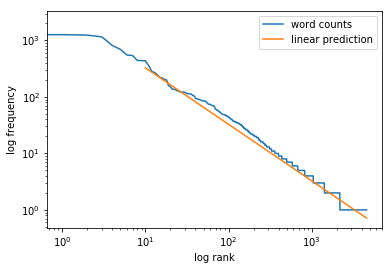

In [55]:
# Word frequency is linear on log-log scale
plt.figure()
plt.loglog(wordcounts, label='word counts');
plt.ylabel('log frequency')
plt.xlabel('log rank')

# Prediction from Zipf's law, using manually chosen parameters.
# We omit the first 'skip' words, which don't fit the prediction well.
skip = 10.0
x = np.arange(skip, len(wordcounts)) 
N = np.sum(wordcounts)
kappa = 0.1
a = -1
y = kappa*np.power(x, a) * N # predicted frequency for word with rank x
plt.loglog(x, y, label='linear prediction')

plt.legend()
plt.show()


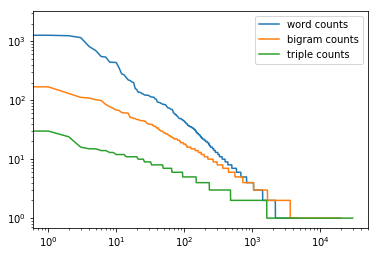

In [56]:
# The number of unique n-grams is smaller for larger n.
# But n-gram statistics also exhibit a power law.

plt.figure()
plt.loglog(wordcounts, label='word counts');
plt.loglog(bigramcounts, label='bigram counts');
plt.loglog(triplecounts, label='triple counts');
plt.legend();
plt.show()
